In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import datasets, layers, models


from keras.layers import Dense
from keras import datasets, layers, models
import math

from sklearn.cluster import KMeans
import tensorflow as tf
from keras import layers, datasets, models
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
df = pd.read_csv("/content/Train.csv")

In [ ]:
df.dropna(subset=['PM2.5'], inplace=True)

In [ ]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [ ]:
training_set = df.iloc[:, 5:6].values
len(training_set)

27233

In [ ]:
training_set = training_set[-5000:]

In [ ]:
training_set.shape

(5000, 1)

In [ ]:
training_set

array([[21.],
       [22.],
       [27.],
       ...,
       [ 5.],
       [17.],
       [10.]])

In [ ]:
# normalize your data for RNN
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
lag = 48  # Number of hours to use as input to predict the next hour.
n_obs = 5000  # Total number of hourly observations in your training set.

X_train = []
y_train = []

for i in range(lag, n_obs):
    X_train.append(training_set_scaled[i-lag:i, 0])  # The previous 48 hours' data.2 days
    y_train.append(training_set_scaled[i, 0])  # The current hour's data to predict.

# Convert lists to numpy arrays for training the BiRNN.
X_train, y_train = np.array(X_train), np.array(y_train)

# Check the shape of X_train to understand the dimensions of the input data.
X_train.shape

(4952, 48)

In [ ]:
# specify or add indicators(here 1, ph)
# keras documentation-> Recurrent Layers -> Input shape: (batch_size,timesteps,input_dim)
batch_size = X_train.shape[0]
timesteps = X_train.shape[1]

X_train = np.reshape(X_train, (batch_size, timesteps, 1))

# **BI RNN**

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense, Bidirectional
from keras.activations import relu

model = Sequential()

# Adding the first Bidirectional RNN layer with 200 units and ReLU activation
model.add(Bidirectional(SimpleRNN(units=200, return_sequences=True, activation='relu'),
                        input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding a second Bidirectional RNN layer with 100 units and ReLU activation
model.add(Bidirectional(SimpleRNN(units=100, return_sequences=True, activation='relu')))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding a third Bidirectional RNN layer with 50 units and ReLU activation
model.add(Bidirectional(SimpleRNN(units=50, return_sequences=True, activation='relu')))
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the last Bidirectional RNN layer with 50 units and ReLU activation
model.add(Bidirectional(SimpleRNN(units=50, activation='relu')))  # No return_sequences since this is the last RNN layer
model.add(Dropout(rate=0.1))  # Applying 10% dropout

# Adding the output layer with a single output neuron
model.add(Dense(units=1))



In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

# Assuming X_train and y_train are already prepared
model.fit(X_train, y_train, epochs=50, batch_size=32)


Epoch 1/50
155/155 [==============================] - 30s 147ms/step - loss: 0.0023
Epoch 2/50
155/155 [==============================] - 23s 146ms/step - loss: 0.0013
Epoch 3/50
155/155 [==============================] - 25s 164ms/step - loss: 0.0011
Epoch 4/50
155/155 [==============================] - 23s 146ms/step - loss: 0.0012
Epoch 5/50
155/155 [==============================] - 22s 139ms/step - loss: 0.0011
Epoch 6/50
155/155 [==============================] - 23s 147ms/step - loss: 0.0010
Epoch 7/50
155/155 [==============================] - 23s 146ms/step - loss: 9.3511e-04
Epoch 8/50
155/155 [==============================] - 24s 154ms/step - loss: 0.0010
Epoch 9/50
155/155 [==============================] - 22s 141ms/step - loss: 9.9111e-04
Epoch 10/50
155/155 [==============================] - 22s 144ms/step - loss: 9.8099e-04
Epoch 11/50
155/155 [==============================] - 23s 147ms/step - loss: 0.0012
Epoch 12/50
155/155 [==============================] - 23s 146

Making the predictions and visualising the results

In [ ]:
# transform and create sequences for Test data
dataset_test = pd.read_csv('/content/Test.csv')


In [ ]:
dataset_test.dropna(subset=['PM2.5'], inplace=True)

In [ ]:
real_PM2 = dataset_test['PM2.5'].values
real_PM2

array([10., 26., 11., ..., 16., 21., 19.])

In [ ]:
# Convert numpy arrays to pandas DataFrames
training_set_df = pd.DataFrame(training_set, columns=['PM2.5'])
dataset_test_df = pd.DataFrame(dataset_test, columns=['PM2.5'])

# Concatenate the two DataFrames along the axis=0 (vertically)
data_set_total = pd.concat([training_set_df, dataset_test_df], axis=0)
data_set_total

,PM2.5
0,21.0
1,22.0
2,27.0
3,26.0
4,27.0
...,...
7008,12.0
7009,13.0
7010,16.0
7011,21.0


In [ ]:
data_set_total.reset_index(drop=True, inplace=True)

In [ ]:

inputs = data_set_total[len(data_set_total)- len(dataset_test) - 48:].values
# reshape inputs to get a numpy array with rows and one column
inputs = inputs.reshape(-1,1)
# scale inputs (like what we did with training set)
inputs = sc.transform(inputs)
X_test = []
# test set contains 7013 observations
for i in range (48,inputs.shape[0]):
  X_test.append(inputs[i-48:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, 1))


In [ ]:
pred_PM2 = model.predict(X_test)
pred_PM2

216/216 [==============================] - 8s 34ms/step


array([[0.01471396],
       [0.01322937],
       [0.02834703],
       ...,
       [0.01622894],
       [0.01891406],
       [0.02421731]], dtype=float32)

In [ ]:
pred_PM2 = model.predict(X_test)
# rescale to original format
pred_PM2 = sc.inverse_transform(pred_PM2)
RMSE = np.sqrt(np.mean((pred_PM2 - real_PM2)**2))
RMSE

216/216 [==============================] - 9s 40ms/step


124.09899141053303

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_PM2, pred_PM2))

# Calculate MAE
mae = mean_absolute_error(real_PM2, pred_PM2)

# Calculate MSE
mse = mean_squared_error(real_PM2, pred_PM2)

# Calculate MAPE - Note: You have to ensure real_PM2 does not contain zeros to avoid division by zero
mape = np.mean(np.abs((real_PM2 - pred_PM2) / real_PM2)) * 100

# Calculate R-squared
r2 = r2_score(real_PM2, pred_PM2)

# Print the results
print('RMSE: {:.4f}'.format(rmse))
print('MAE: {:.4f}'.format(mae))
print('MSE: {:.4f}'.format(mse))
print('MAPE: {:.4f}%'.format(mape))
print('R-squared: {:.4f}'.format(r2))

RMSE: 22.6727
MAE: 12.7684
MSE: 514.0519
MAPE: 318.1211%
R-squared: 0.9271


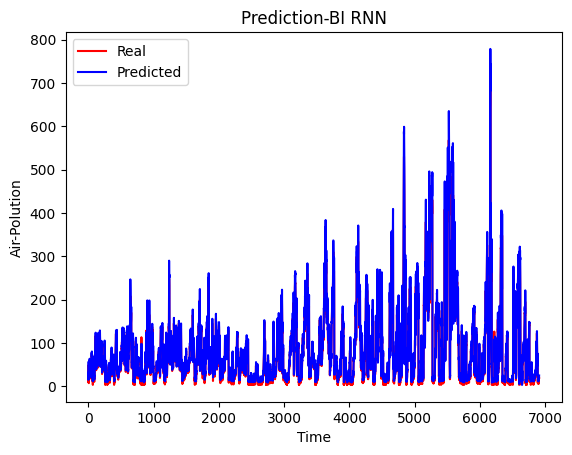

In [ ]:
plt.plot(real_PM2, color = 'red', label = 'Real')
plt.plot(pred_PM2, color = 'blue', label = 'Predicted')
plt.title('Prediction-BI RNN')
plt.xlabel('Time')
plt.ylabel('Air-Polution')
plt.legend()
plt.show()